## Import Modules

In [1]:
# Import Data Analysis libraries
import pandas as pd
import numpy as np

# Import Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

# Import ML libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

## Load Dataset

In [2]:
train_df = pd.read_csv('./Data/train.csv')
test_df = pd.read_csv('./Data/test.csv')

datasets = [train_df, test_df] # useful for performing operations on both dataframes

#train_df.head(3)
#test_df.head(3)

**Data Dictionary**

URL:  https://www.kaggle.com/c/titanic/data

**`Variable:`  Definition**
- `survival:` Survival	
- `pclass:` Ticket class. A proxy for socio-economic status (SES)

        1st = Upper
        2nd = Middle
        3rd = Lower	
- `sex:` Male/Female	
- `Age:` Age in years. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5	
- `sibsp:` # of siblings / spouses aboard the Titanic The dataset defines family relations in this way...
        
        Sibling = brother, sister, stepbrother, stepsister
        Spouse = husband, wife (mistresses and fiancés were	
- `parch:` # of parents / children aboard the Titanic. The dataset defines family relations in this way...

        Parent = mother, father
        Child = daughter, son, stepdaughter, stepson
        Some children travelled only with a nanny, therefore parch=0 for them.	
- `ticket:` Ticket number	
- `fare:` Passenger fare	
- `cabin:` Cabin number	
- `embarked:` Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

**Key**
- 0 = No, 1 = Yes
- 1 = 1st, 2 = 2nd, 3 = 3rd

** Describe the data set**
- Catagorical features: `Survived`, `Pclass`, `Sex`, `Cabin`, `Embarked`
- Nuberical features: `Age`, `Fare`, `SibSp`, `Parch`
- 891 total passengers. 64.7% were male (577 freq), 35.2% were female (314 freq)
- Around 38.4% of the passengers survived. Real survivor rate was ~32%
- There is a lot of duplication in the `ticket` feature (23.5% duplicates, 681 unique entries)
- There are 3 possible port in the `Embarked` feature
- `Age`, `Cabin`, and `Embarked` have missing values. They will be addressed below


In [3]:
print ('-'*15 + 'Train' + '-'*15)
print(train_df.info())
print ('-'*15 + 'Test' + '-'*15)
print(test_df.info())

---------------Train---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
---------------Test---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-nul

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Sage, Mr. Frederick",male,1601,B96 B98,S
freq,1,577,7,4,644


## Clean Data & Feature Engineering

I will be applying the fixes to both `train_df` and `test_df` by iterating through the `datasets` list.

**--- `Age` ---**

- Fill the missing ages with the mean age of the each gender

In [6]:
# Let us examine the mean age of passengers broken out by Gender in train_df. 
print('-----Train-----')
print(train_df[['Sex','Age']].groupby(['Sex']).mean())
print('-----Test-----')
# Let us examine the mean age of passengers broken out by Gender in test_df. 
print(test_df[['Sex','Age']].groupby(['Sex']).mean())

-----Train-----
              Age
Sex              
female  27.915709
male    30.726645
-----Test-----
              Age
Sex              
female  30.272362
male    30.272732


In [7]:
# iterate through test and train datasets
for df in datasets:
    
    # Calculate the mean ages for male and female passengers
    mean_female_age = df.groupby(['Sex']).mean().loc['female','Age']
    mean_male_age = df.groupby(['Sex']).mean().loc['male','Age']
   
    # select female & age = Null
    df.loc[(df.Sex == 'female') & (df.Age.isnull()),'Age'] = mean_female_age
    # select male & age = Null
    df.loc[(df.Sex == 'male') & (df.Age.isnull()),'Age'] = mean_male_age

In [8]:
# Check to see if the Nulls have gone
train_df[['Age']].info()
#test_df[['Age']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
Age    891 non-null float64
dtypes: float64(1)
memory usage: 7.0 KB


**--- `Cabin` ---**

- Lot of values are missing the Cabin info - only ~23% of the samples have cabin info. 
- Let us extract the first letter of the `Cabin` to a separate `Deck` column. 
- For missing samples with missing `Cabin` info, I will categorize the `Deck` as 'U' for Unknown.
- A few samples have multiple Cabins per line (eg. B82 B84). For same of simplicity, I will use the first cabin to determin the Deck (B82 `->` Deck B)

In [9]:
# Summary of what the Cabin feature looks like
train_df.Cabin.value_counts().head()

B96 B98        4
G6             4
C23 C25 C27    4
F33            3
C22 C26        3
Name: Cabin, dtype: int64

In [10]:
for df in datasets:
    # Label all NaN Cabin values = Unknown
    df.loc[df.Cabin.isnull(), 'Cabin'] = 'Unknown'
    
    # Take the first letter of the Cabin, and use it as the 'Deck'
    df['Deck'] = df.Cabin.map(lambda x: str(x).split()[0][0])

In [11]:
# Summary of the Deck Feature
train_df['Deck'].value_counts()

U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Deck, dtype: int64

In [12]:
test_df['Deck'].value_counts()

U    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Deck, dtype: int64

**--- `Embarked` ---**
- There are three ports of Embarkation: C = Cherbourg, Q = Queenstown, S = Southampton.
- For the missing entries, we will estimate the port of Embarkation based on the most frequent Port.

In [13]:
# Breakdown of passengers by Port of Embarkation. Most frequent is Southhampton 'S'
train_df.Embarked.value_counts()
#test_df.Embarked.value_counts() #uncomment to check test_df

# (optional) review which entries have NaN for age
#train_df[train_df.Embarked.isnull()] 

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [14]:
# Fill in missing values with the most frequent port
for df in datasets:
    # Get the name of the most frequent port by using value counts
    max_port = df.Embarked.value_counts().index.tolist()[0]

    # Label missing entries with the most frequent port (Southhampton 'S')
    df.loc[df.Embarked.isnull(),'Embarked'] = max_port

In [15]:
# Check to see if the Nulls have gone
train_df[['Embarked']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
Embarked    891 non-null object
dtypes: object(1)
memory usage: 7.0+ KB


**--- `Parch` & `SibSp` ---**
- Let us combine the parents, childern, sibilings, spouses info in a new `FamilySize` feature

In [16]:
for df in datasets:
    # adding +1 for the person him/herself
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1

In [17]:
#Review the breakdown of family sizes in 
train_df.FamilySize.value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

Given that the vast majority of the samples have `FamilySize` <= 4. Let us band the FamilySize into the following buckets: 1, 2, 3, 4, 5+

In [18]:
for df in datasets:
    df.loc[df['FamilySize'] >= 5, 'FamilySize'] = '5+'

**---Fare---**
- In the test_df, `Fare` feature has Null values
- Passengers who survived paid on average more than double the fare than those who perished (`$48` vs  `$22`) 
- Both `train` and `test` datasets have very similar breakdown in prices (quartile data)

In [19]:
# Fill missing values with median Fare
for df in datasets:
    df.loc[df.Fare.isnull(),'Fare'] = df.Fare.median()

In [20]:
# Mean fare paid by surviving passengers
train_df[['Fare','Survived']].groupby('Survived').mean()

,Fare
Survived,
0,22.117887
1,48.395408


In [21]:
#Describe the Fares paid in the Train and Test datasets
print ('-------Train-------')
print(train_df.Fare.describe())
print ('-------Test-------')
print(test_df.Fare.describe())

-------Train-------
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64
-------Test-------
count    418.000000
mean      35.576535
std       55.850103
min        0.000000
25%        7.895800
50%       14.454200
75%       31.471875
max      512.329200
Name: Fare, dtype: float64


Let's transform the `Fare` variable into a categorical field based on the quartiles:

In [22]:
for df in datasets:
    df['Fare_bracket'] = pd.cut(df['Fare'],[0,8,15,32,550],
                                labels =['[0-8)','[8-15)','[15-32)','[32+)'], right = False)
    
train_df['Fare_bracket'].value_counts()

[0-8)      241
[15-32)    223
[8-15)     216
[32+)      211
Name: Fare_bracket, dtype: int64

**---Title---**
- Let us extract the titles from the names

In [23]:
#Extract the titles
for df in datasets:
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [24]:
#Lets look at the top values of Titles in both datasets. Note that 'Dona' appears only in test_df
pd.concat([train_df.Title.value_counts(), test_df.Title.value_counts()], 
              keys=['Train','Test'],axis = 1).sort_values('Train', ascending=False)

,Train,Test
Mr,517.0,240.0
Miss,182.0,78.0
Mrs,125.0,72.0
Master,40.0,21.0
Dr,7.0,1.0
Rev,6.0,2.0
Major,2.0,NaN
Col,2.0,2.0
Mlle,2.0,NaN
Mme,1.0,NaN


Most of the samples have titles of Mr, Miss, Mrs, or Master. Therefore we will group the other titles as 'Other'

In [25]:
for df in datasets:
    df['Title'] = df['Title'].replace('Mme','Mrs')
    df['Title'] = df['Title'].replace('Ms','Miss')
    df['Title'] = df['Title'].replace('Mlle','Miss')
    
    #group other titles as 'Other'
    df['Title'] = df['Title'].replace(['Capt','Col','Countess','Don','Dona','Dr',
                                       'Jonkheer','Lady','Major','Rev','Sir'], 'Other')

**---Sex---**
- Set Male = 1 and Female = 0

In [26]:
# Change Sex to 1=male, 0=female
for df in datasets:
    df.loc[df.Sex == 'male','Sex'] = 1
    df.loc[df.Sex == 'female','Sex'] = 0

In [27]:
train_df.Sex.value_counts()
#test_df.Sex.value_counts()

1    577
0    314
Name: Sex, dtype: int64

## Analysis

Let us view the influence of the different feature on the Survival rate. We will plot each feature against the Surival Rate to see which features to include in our ML model.

In [28]:
#Let us remid ourselves of the training dataset:
train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,FamilySize,Fare_bracket,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,Unknown,S,U,2,[0-8),Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,C,2,[32+),Mrs
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,U,1,[0-8),Miss


In [29]:
def plot_helper (dataframe, title):
    '''
    Helper funcion for plotting
    '''
    ax = dataframe.plot(kind = "barh", figsize =(7,5), xlim=(0.0,1.0))
    #ax.set_xlabel (x_label)
    ax.set_title (title)
    
    for p in ax.patches:
        ax.annotate (str(round(p.get_width(),3)),
                     xy=(p.get_x()+0.02, p.get_y()+p.get_height()/2.5),
                     color = "white" )
    plt.show()

Fare vs Survived

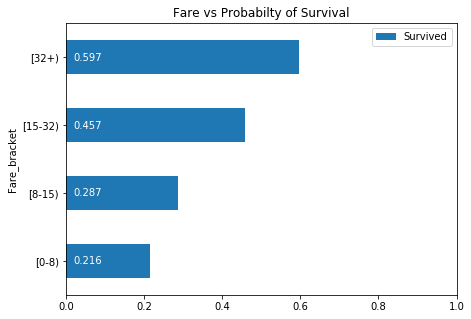

In [30]:
plot_helper(train_df[['Fare_bracket','Survived']].groupby(['Fare_bracket']).mean(),
            "Fare vs Probabilty of Survival")

Sex vs Survived

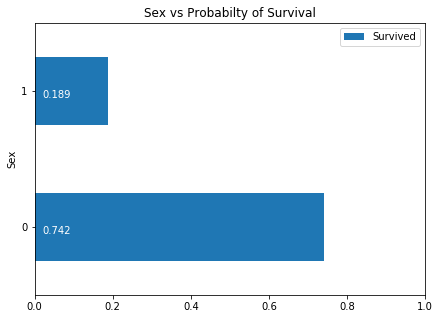

In [31]:
plot_helper(train_df[['Sex','Survived']].groupby(['Sex']).mean(),
            "Sex vs Probabilty of Survival")

Title vs Survived

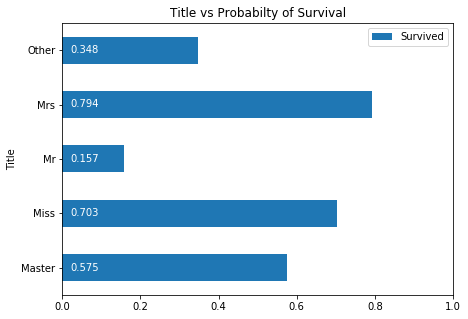

In [32]:
plot_helper(train_df[['Title','Survived']].groupby(['Title']).mean(),
            "Title vs Probabilty of Survival")

FamilySize vs Survived

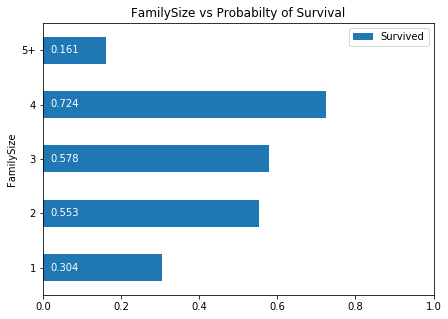

In [33]:
plot_helper(train_df[['FamilySize','Survived']].groupby(['FamilySize']).mean(),
            "FamilySize vs Probabilty of Survival")

Class vs Survived

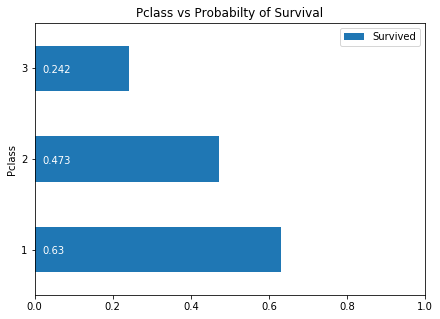

In [34]:
plot_helper(train_df[['Pclass','Survived']].groupby(['Pclass']).mean(),
            "Pclass vs Probabilty of Survival")

Deck vs Survived

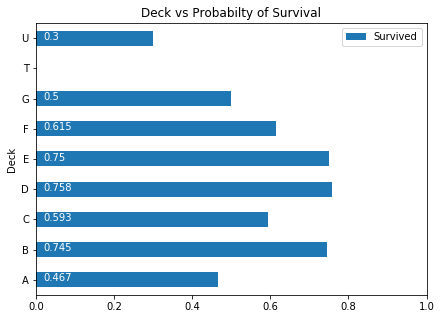

In [35]:
plot_helper(train_df[['Deck','Survived']].groupby(['Deck']).mean(),
            "Deck vs Probabilty of Survival")

## Building ML Model
One Hot Encode Catagorical Features

In [36]:
#One Hot Encode the Embarked column for ML 
train_ML = pd.get_dummies(train_df, columns = ['Embarked', 'Pclass','FamilySize','Title','Fare_bracket','Deck'])
test_ML = pd.get_dummies(test_df, columns = ['Embarked', 'Pclass','FamilySize','Title','Fare_bracket','Deck'])

Drop PassengerId, Name, SibSp, Parch, Ticket

In [37]:
train_ML.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin','Fare'], axis = 1, inplace = True)
test_ML.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin','Fare'], axis = 1, inplace = True)

In [38]:
print(train_ML.columns)
print(test_ML.columns)

Index(['Survived', 'Sex', 'Age', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'FamilySize_1', 'FamilySize_2',
       'FamilySize_3', 'FamilySize_4', 'FamilySize_5+', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other',
       'Fare_bracket_[0-8)', 'Fare_bracket_[8-15)', 'Fare_bracket_[15-32)',
       'Fare_bracket_[32+)', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_T', 'Deck_U'],
      dtype='object')
Index(['Sex', 'Age', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'FamilySize_1', 'FamilySize_2', 'FamilySize_3',
       'FamilySize_4', 'FamilySize_5+', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Other', 'Fare_bracket_[0-8)',
       'Fare_bracket_[8-15)', 'Fare_bracket_[15-32)', 'Fare_bracket_[32+)',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Deck_U'],
      dtype='object')


Note that the `test_df` does not have Deck T. Given that there was only sample with `Deck` = T, we will drop `Deck_T` from the `train_df` while building our models (for the sake of simplicity).

In [39]:
train_ML.drop('Deck_T', axis = 1, inplace = True)

In [40]:
# Drop dummy variables
train_ML.drop('Embarked_C', axis = 1, inplace = True)
test_ML.drop('Embarked_C', axis = 1, inplace = True)

train_ML.drop('Pclass_3', axis = 1, inplace = True)
test_ML.drop('Pclass_3', axis = 1, inplace = True)

train_ML.drop('Title_Other', axis = 1, inplace = True)
test_ML.drop('Title_Other', axis = 1, inplace = True)

train_ML.drop('FamilySize_5+', axis = 1, inplace = True)
test_ML.drop('FamilySize_5+', axis = 1, inplace = True)

Create Feature and Response Vectors

In [41]:
y = train_ML.Survived
X = train_ML.drop('Survived', axis = 1)
X_tst= test_ML

**Null Accuracy** 

Accuracy that could be achieved by always predicting the most frequent class (which in this case is `survived` = 0). We can use this as a baseline to measure against our models

In [42]:
print ('Null Accuracy (survive = 0): ', 1-y.mean())

Null Accuracy (survive = 0):  0.6161616161616161


***Logistic Regression***

In [43]:
logreg = LogisticRegression()

scores = cross_val_score(logreg, X, y, cv=10, scoring = 'accuracy')

print ('Mean Score: ', scores.mean())
print (scores)

Mean Score:  0.835027238679
[ 0.8         0.86666667  0.7752809   0.86516854  0.85393258  0.83146067
  0.83146067  0.80898876  0.87640449  0.84090909]


***Decision Trees***

In [44]:
tree = DecisionTreeClassifier()
scores = cross_val_score(tree, X, y, cv=10, scoring = 'accuracy')

print ('Mean Score: ', scores.mean())
print (scores)


Mean Score:  0.806973953013
[ 0.74444444  0.85555556  0.74157303  0.83146067  0.78651685  0.78651685
  0.80898876  0.80898876  0.8988764   0.80681818]


*** K-Nearest Neighbors ***

[0.74524940415389851, 0.74190330268981952, 0.77780955623652248, 0.76321501532175684, 0.78123113154012025, 0.76773464986948137, 0.77004483032572912, 0.75206645102712522, 0.76440160027238668, 0.74749602769265677, 0.76552491204176598, 0.75875780274656679, 0.75769691294972197, 0.74754624900692312, 0.74648564294631714, 0.74196600839859261, 0.74870758143230054, 0.73632277834525017, 0.74644790602655764, 0.73295170809215748, 0.74639740097605256, 0.73742083758937693, 0.73519889910339331, 0.72277579162410621, 0.73177732379979565, 0.72054136874361596, 0.72167744864374073, 0.71156480535694011, 0.72057910566337535, 0.70935535126546356, 0.70934258313471799, 0.70256327318125078, 0.71041595732606977, 0.69809414368403133, 0.70482294858699357, 0.69808137555328564, 0.69806832368630123, 0.69133923504710026, 0.69583390080581098]


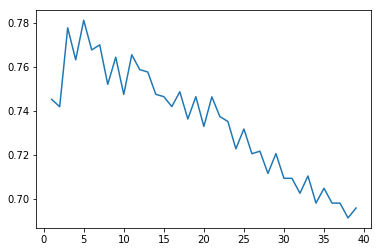

In [45]:
#Optional - visually fid the optimal K value. We will use Grid Search CV instead
k_range = range (1,40)
k_scores = []
for n in k_range:
    knn = KNeighborsClassifier (n_neighbors = n)
    scores = cross_val_score(knn, X,y,cv=10, scoring ='accuracy')
    k_scores.append(scores.mean())
    
print  (k_scores)
plt.plot(k_range, k_scores)

Trying GridSearchCV for optimal n_neighbor value in KNN

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
k_range = list(range (1,31))
param_grid = dict(n_neighbors = k_range)

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')

grid.fit (X,y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [48]:
# examine best model
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.781144781145
{'n_neighbors': 5}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


*** SVC ***

In [49]:
svc = svm.SVC()

scores = cross_val_score(svc, X, y, cv=10, scoring = 'accuracy')

print ('Mean Score: ', scores.mean())
print (scores)

Mean Score:  0.796836057201
[ 0.77777778  0.82222222  0.74157303  0.88764045  0.79775281  0.75280899
  0.79775281  0.75280899  0.85393258  0.78409091]


## Winning Model Seems to be Logistic Regression with score of 0.835

In [50]:
logreg.fit(X,y)
y_pred = logreg.predict(X_tst)

In [51]:
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'],
    'Survived':y_pred})

submission.to_csv('./submission_v13.csv', index=False)

---------
**>CHEAT CELL: Lists all changes in one cell**

In [ ]:
train_df = pd.read_csv('./Data/train.csv')
test_df = pd.read_csv('./Data/test.csv')

datasets = [train_df, test_df]

# iterate through test and train datasets
for df in datasets:
    
    # Age
    mean_female_age = df.groupby(['Sex']).mean().loc['female','Age']
    mean_male_age = df.groupby(['Sex']).mean().loc['male','Age']
    df.loc[(df.Sex == 'female') & (df.Age.isnull()),'Age'] = mean_female_age
    df.loc[(df.Sex == 'male') & (df.Age.isnull()),'Age'] = mean_male_age

    # Cabin
    df.loc[df.Cabin.isnull(), 'Cabin'] = 'Unknown'
    df['Deck'] = df.Cabin.map(lambda x: str(x).split()[0][0])
    
    # Embarked
    max_port = df.Embarked.value_counts().index.tolist()[0]
    df.loc[df.Embarked.isnull(),'Embarked'] = max_port
    
    #Parch SibSP
    df['FamilySize'] = df['Parch'] + df['SibSp'] + 1
    df.loc[df['FamilySize'] >= 5, 'FamilySize'] = '5+'
    
    #Fare
    df.loc[df.Fare.isnull(), 'Fare'] = df.Fare.median()
    df['Fare_bracket'] = pd.cut(df['Fare'],[0,8,15,32,550],
                            labels =['[0-8)','[8-15)','[15-32)','[32+)'], right = False)
    
    #Title    
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace('Mme','Mrs')
    df['Title'] = df['Title'].replace('Ms','Miss')
    df['Title'] = df['Title'].replace('Mlle','Miss')  
    df['Title'] = df['Title'].replace(['Capt','Col','Countess','Don','Dona','Dr',
                                       'Jonkheer','Lady','Major','Rev','Sir'], 'Other')
    
    #Sex
    df.loc[df.Sex == 'male','Sex'] = 1
    df.loc[df.Sex == 'female','Sex'] = 0